In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# パッケージのインストール&インポート
!pip install rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio

import json
import os
import glob

import time
from datetime import datetime
from dateutil.parser import parse

from PIL import Image, ImageDraw, ImageFont

In [ ]:
!pip install folium

import folium

関心域のポリゴン作成およびその位置情報を取得するWebアプリを作成しました．以下のサイトより，関心粋の選択（左の作成チールより四角を選択），ポリゴンを作成。その後”Show feature”をクリックしポリゴン情報を右枠に表示させ、Copyを押して情報をコピーする。

In [5]:
#関心領域のポリゴン情報の取得．
from IPython.display import HTML
HTML(r'<iframe width="1000" height="580" src="https://gispolygon.herokuapp.com/" frameborder="0"></iframe>')

ポリゴン情報をコピーし，以下のAの右辺にペーストする．

In [41]:
A  = {"type":"FeatureCollection","features":[{"properties":{"note":"","distance":"35937.06 m","drawtype":"rectangle","area":"12713.15 ha"},"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[139.71197873353958,35.33475055335104],[139.71197873353958,35.452996930987666],[139.81840878725052,35.452996930987666],[139.81840878725052,35.33475055335104],[139.71197873353958,35.33475055335104]]]}}]}

In [42]:
#今後使用する任意のファイル名をセットする． 例えば，地域の名前など．
object_name = 'tokyobay3'

In [43]:
with open(str(object_name) +'_2.geojson', 'w') as f:
    json.dump(A, f)

In [44]:
json_file = open(str(object_name) +'_2.geojson')
json_object = json.load(json_file)

In [45]:
#jsonから関心域の緯度・経度情報のみを抽出する．

AREA = json_object["features"][0]["geometry"]['coordinates'][0]

関心域の確認


In [46]:
m = folium.Map([(AREA[0][1]+AREA[len(AREA)-2][1])/2,(AREA[0][0]+AREA[len(AREA)-3][0])/2], zoom_start=11)

folium.GeoJson(str(object_name) +'_2.geojson').add_to(m)
m

In [47]:
region=ee.Geometry.Polygon(AREA)

In [48]:
region['coordinates'][0]

[[139.71197873353958, 35.33475055335104],
 [139.71197873353958, 35.452996930987666],
 [139.81840878725052, 35.452996930987666],
 [139.81840878725052, 35.33475055335104],
 [139.71197873353958, 35.33475055335104]]

Sentinel-1

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

Dataset Availability
2014-10-03T00:00:00 - 2020-08-13T00:00:00

Mauritiusは通常はEWモードでの観測．




In [49]:
# 期間を指定
from_date='2019-01-01'
to_date='2020-08-31'

# 保存するフォルダ名
dir_name_s1 = 'GEE_Sentinel1_' + object_name

In [50]:

def ImageExport(image,description,folder,region,scale):
    task = ee.batch.Export.image.toDrive(image=image,description=description,folder=folder,region=region,scale=scale)
    task.start()


Sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(region).filterDate(parse(from_date),parse(to_date)).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select(['VV'])

imageList_s1 = Sentinel1.toList(300)

In [51]:
for i in range(imageList_s1.size().getInfo()):
    image = ee.Image(imageList_s1.get(i))
    ImageExport(image.reproject(crs='EPSG:4326',scale=10),image.get('system:index').getInfo(),dir_name_s1,region['coordinates'][0],10)

52


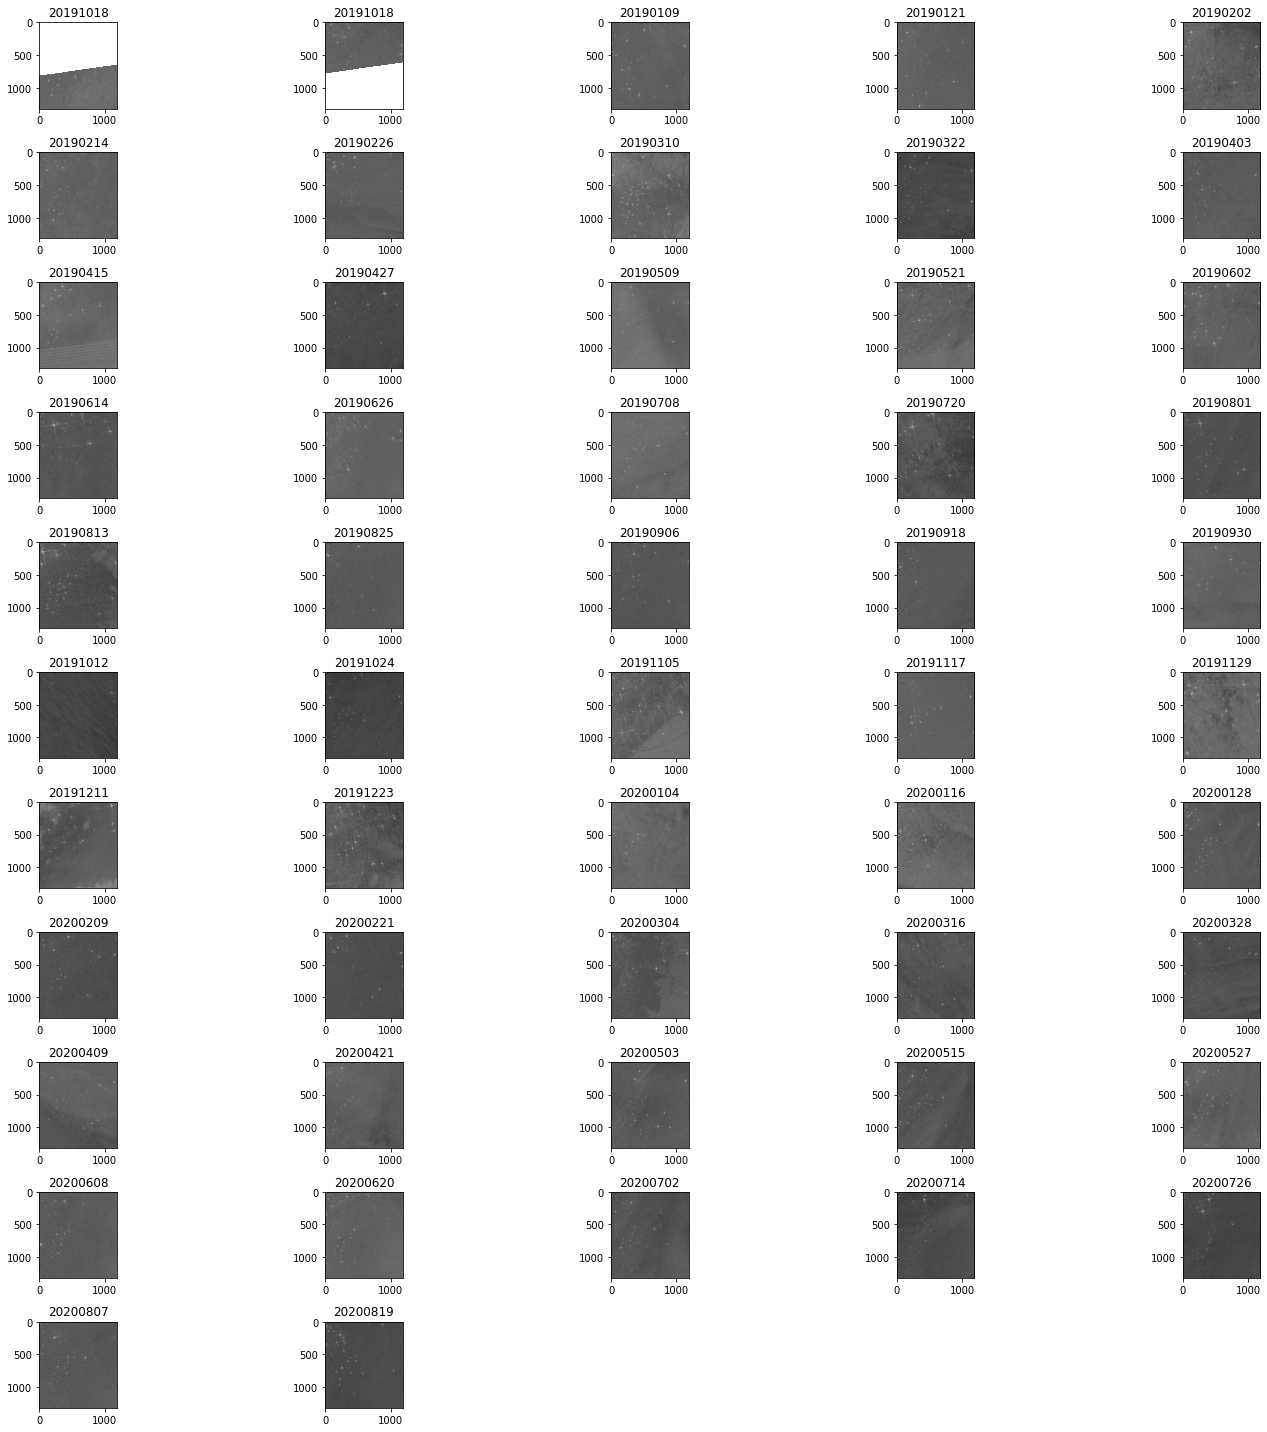

In [52]:
# 時系列で可視化
s1_path = '/content/drive/My Drive/' + dir_name_s1 + '/'
files =os.listdir(s1_path)
files.sort()

print(len(files))
plt.figure(figsize=(20, 20))

j = 0
v = len(files)//5 +1 
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s1_path + files[i]) as src:
      arr = src.read()
  j+=1# 画像のプロット位置をシフトさせ配置
  plt.subplot(v,5,j)
  plt.imshow(arr[0], cmap='gray')
  plt.title(files[i][33:41])# ファイル名から日付を取得
  plt.tight_layout()

20190109


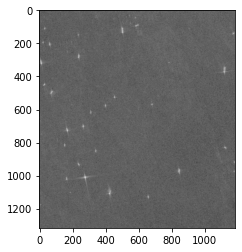

In [53]:
# データの読み込み
n = 2

with rasterio.open(s1_path + files[n]) as src:
    arr = src.read()

print(files[n][33:41])
# 可視化
plt.imshow(arr[0], cmap='gray')

In [54]:
arr[0].shape

(1317, 1186)

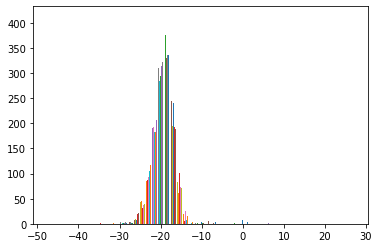

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(arr[0], bins=50)
fig.show()

船の数をカウントする

https://cvtech.cc/cellcount/


20200819


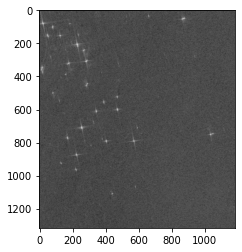

In [62]:
# データの読み込み
n = len(files) -1

with rasterio.open(s1_path + files[n]) as src:
    arr = src.read()

print(files[n][33:41])
# 可視化
plt.imshow(arr[0], cmap='gray')

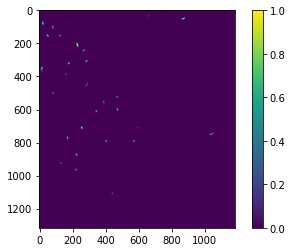

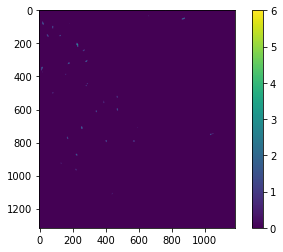

In [63]:
#二値化処理
import cv2

binimg = (arr[0]>0)

plt.imshow(binimg)
plt.colorbar()
plt.show()

#距離マップ(distance map)を計算する
binimg = binimg.astype(np.uint8)
distmap = cv2.distanceTransform(binimg,1,3)

plt.imshow(distmap)
plt.colorbar()
plt.show()

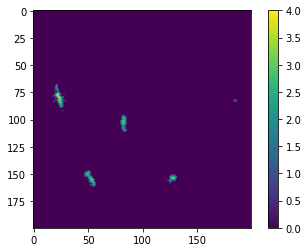

In [64]:
plt.imshow(distmap[0:200,0:200])
plt.colorbar()
plt.show()

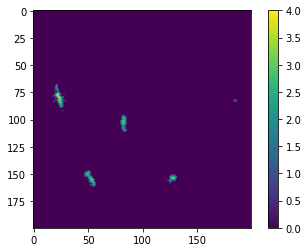

In [65]:
#距離マップの極大値をもつ場所を計算する

out = distmap*0
ksize=100 #100ピクセル以内の最大値
for x in range(ksize,distmap.shape[0]-ksize*2):
    for y in range(ksize,distmap.shape[1]-ksize*2):
        if distmap[x,y]>0 and distmap[x,y]==np.max(distmap[x-ksize:x+ksize,y-ksize:y+ksize]):
            out[x,y]=1

                
plt.imshow(distmap[0:200,0:200])
plt.colorbar()
plt.show()

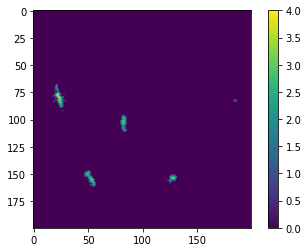

船の数:  15
[[ 441.         1111.5       ]
 [ 444.6        1107.2       ]
 [ 227.          874.5       ]
 [ 574.          791.5       ]
 [ 406.          790.76923077]
 [ 258.5         710.        ]
 [ 473.8         601.        ]
 [ 392.          559.5       ]
 [ 473.          526.        ]
 [ 472.          521.5       ]
 [ 285.          455.5       ]
 [ 292.          444.5       ]
 [ 180.          321.4       ]
 [ 230.5         207.        ]
 [ 127.5         154.        ]]


In [66]:
#膨張させ、輪郭検出し、数える

out = cv2.dilate(out,(10,10)) #10*10に膨張させ，同じ範囲に入っていたらカウントしない

contours, _ = cv2.findContours(out.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

arr=[]
for i in contours:
    x_=0
    y_=0
    for j in i:
        x_ += j[0][0]
        y_ += j[0][1]
    arr.append([x_/len(i), y_/len(i)])
arr = np.array(arr)
                
plt.imshow(distmap[0:200,0:200])
plt.colorbar()
plt.show()

print("船の数: ", len(arr)) 
print(arr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


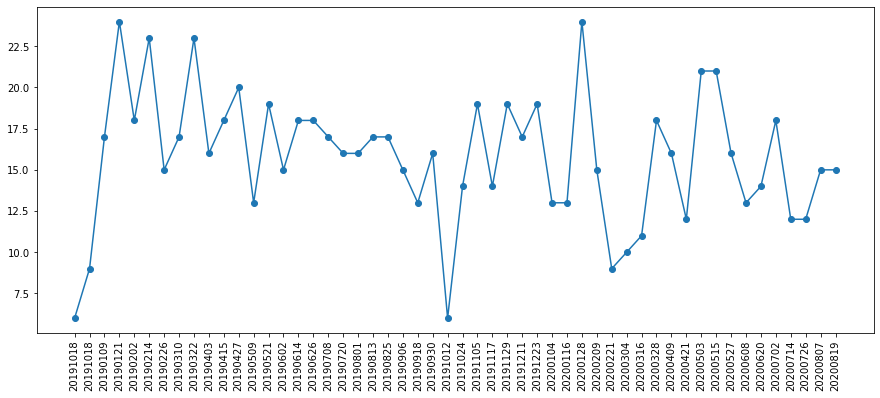

In [61]:
# 当該エリアの推定された船の数を時系列グラフ化

# 時系列で可視化
s1_path = '/content/drive/My Drive/' + dir_name_s1 + '/'
files =os.listdir(s1_path)
files.sort()

sum_ship = []
label_signal = []

for i in range(len(files)):
  label_signal.append(files[i][33:41])
  
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s1_path + files[i]) as src:
      arr = src.read()
  
  #二値化処理
  binimg = (arr[0]>0)

  #距離マップ(distance map)を計算する
  binimg = binimg.astype(np.uint8)
  distmap = cv2.distanceTransform(binimg,1,3)

  out = distmap*0
  ksize=100 #100ピクセル以内の最大値
  for x in range(ksize,distmap.shape[0]-ksize*2):
      for y in range(ksize,distmap.shape[1]-ksize*2):
          if distmap[x,y]>0 and distmap[x,y]==np.max(distmap[x-ksize:x+ksize,y-ksize:y+ksize]):
              out[x,y]=1

  out = cv2.dilate(out,(10,10)) #10*10に膨張させ，同じ範囲に入っていたらカウントしない
  contours, _ = cv2.findContours(out.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  num=[]
  for i in contours:
      x_=0
      y_=0
      for j in i:
          x_ += j[0][0]
          y_ += j[0][1]
      num.append([x_/len(i), y_/len(i)])
  num = np.array(num)


  sum_ship.append(len(num))


# 可視化
fig,ax = plt.subplots(figsize=(15,6))
plt.plot(sum_ship, marker='o')
ax.set_xticks(np.arange(0,len(files)))
ax.set_xticklabels(label_signal, rotation=90)
plt.show()

信号強度の時系列評価


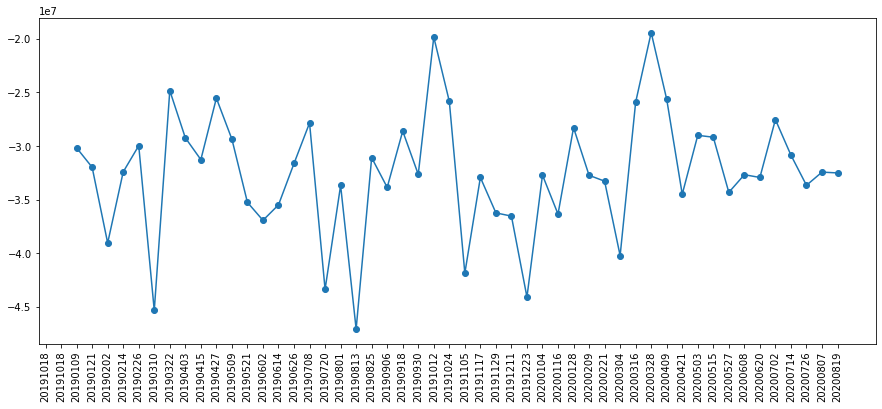

In [67]:
# 当該エリアの反射強度の合計値を時系列グラフ化

# 時系列で可視化
s1_path = '/content/drive/My Drive/' + dir_name_s1 + '/'
files =os.listdir(s1_path)
files.sort()

sum_signal = []
label_signal = []
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s1_path + files[i]) as src:
      arr = src.read()
  sum_signal.append(arr.sum())
  label_signal.append(files[i][33:41])

# 可視化
fig,ax = plt.subplots(figsize=(15,6))
plt.plot(sum_signal, marker='o')
ax.set_xticks(np.arange(0,len(files)))
ax.set_xticklabels(label_signal, rotation=90)
plt.show()